In [1]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM
using SSMCMain.ModifiedMiCRM.RandomSystems

In [2]:
using Base.Threads, OhMyThreads
using ProgressMeter
using BenchmarkTools
using JLD2
using Geppetto
using DataFrames
using DataFramesMeta
using HypothesisTests
using ColorSchemes

In [3]:
includet("../../scripts/figures_util.jl")

using CairoMakie
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# Smooth random functions by integrating normals

In [34]:
?cumsum!

search: cumsum! cumsum ContinuousMatrixDistribution



```
cumsum!(B, A; dims::Integer)
```

Cumulative sum of `A` along the dimension `dims`, storing the result in `B`. See also [`cumsum`](@ref).

!!! warning
    Behavior can be unexpected when any mutated argument shares memory with any other argument.



In [227]:
function kaka(N, mu, sigma, n)
    xs = mu .+ sigma .* randn(N)
    ys = copy(xs)

    while n > 0
        cumsum!(ys, xs)
        xs .= ys
        n -= 1
    end

    reverse!(ys)
    xs .+= ys
    xs ./= 2
    xs
end
function lala(N, mu, sigma, n, m)
    xs = fill(0., N)
    for _ in 1:m
        ys = kaka(N, mu, sigma, n)
        circshift!(ys, rand(1:length(ys)))
        xs .+= ys
    end
    xs
end

lala (generic function with 1 method)

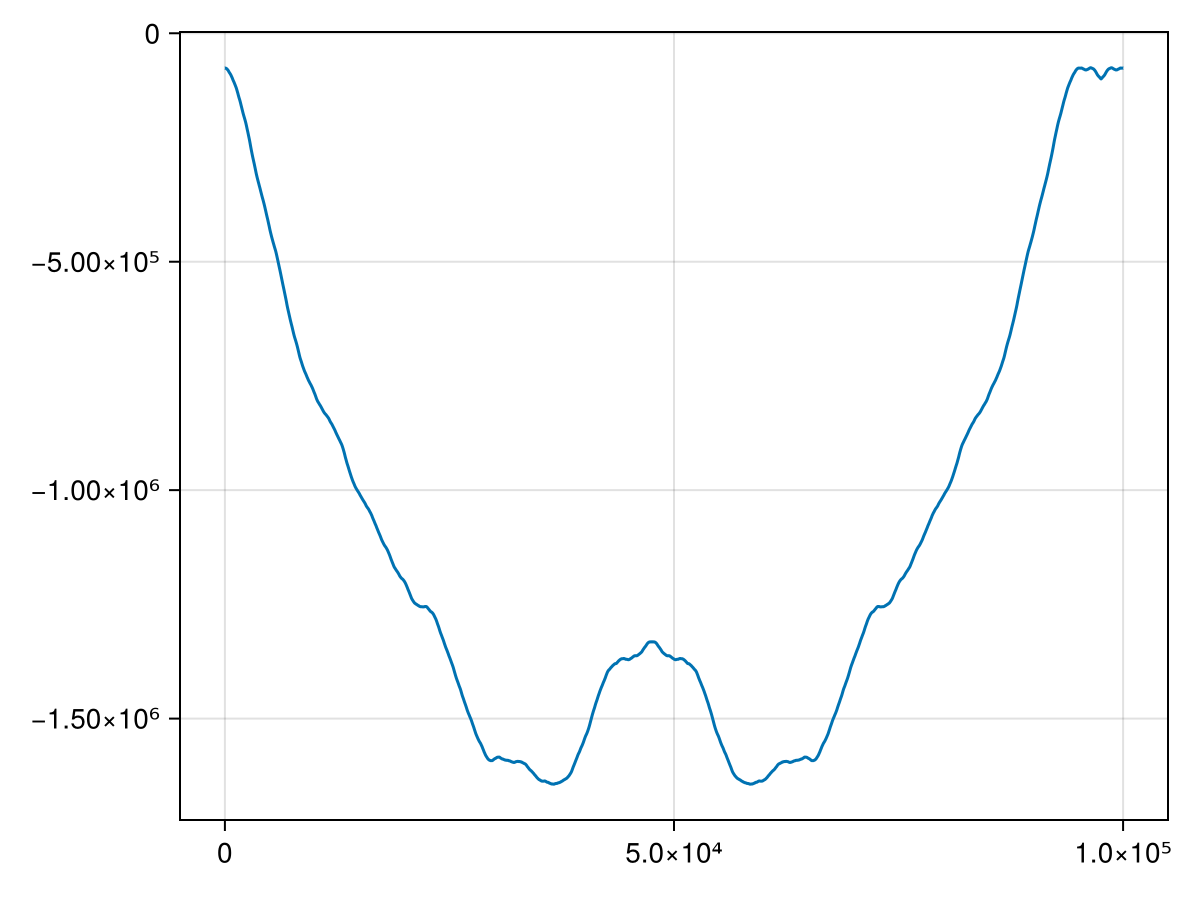

In [259]:
xs = lala(100000, 0., 1., 2, 1)
lines(xs)

In [15]:
cumsum([1, 2, 3, 4, 5])

5-element Vector{Int64}:
  1
  3
  6
 10
 15

In [31]:
m = 0.
s = 1.

xs = m .+ s .* randn(10000000)
ys = cumsum(xs)
zs = cumsum(ys)

nothing

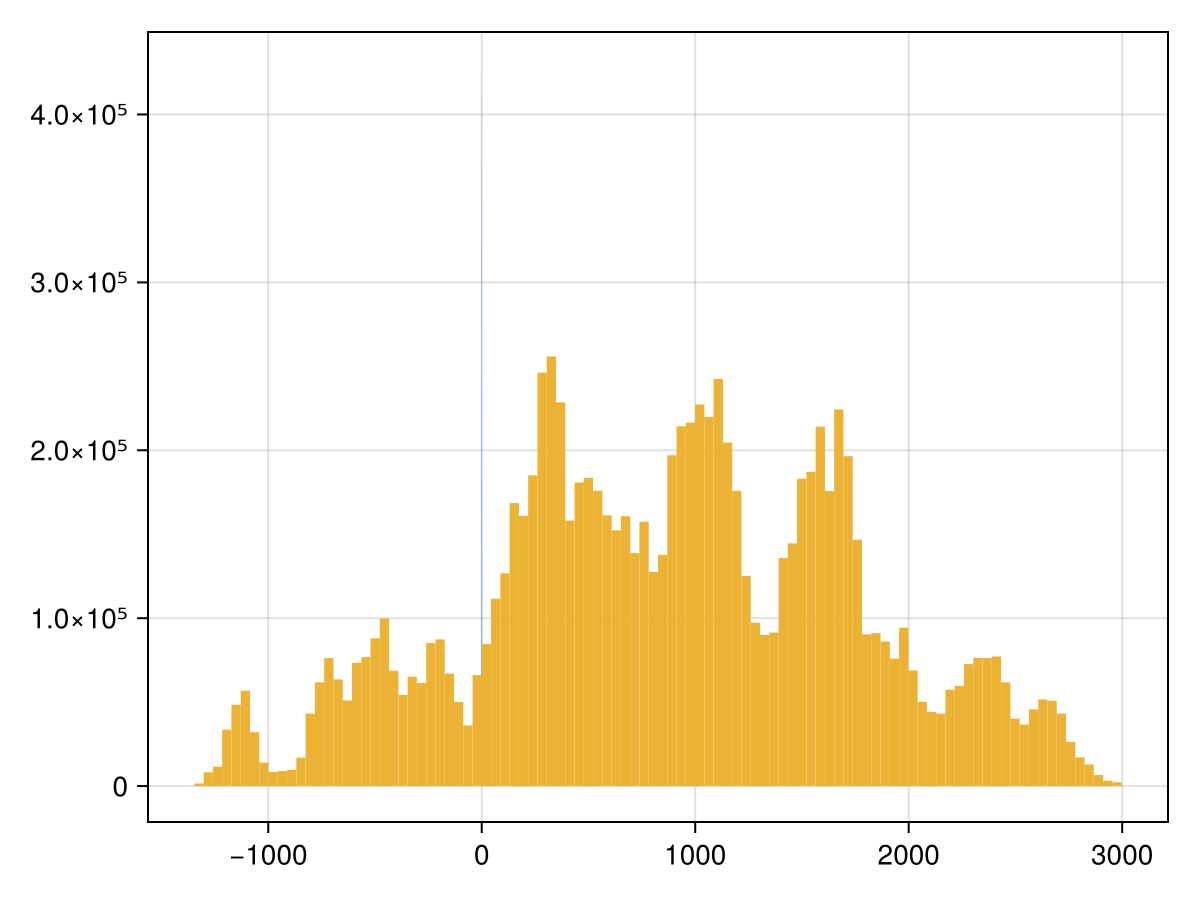

In [32]:
fap = hist(xs; bins=100)
hist!(fap.axis, ys; bins=100)

fap

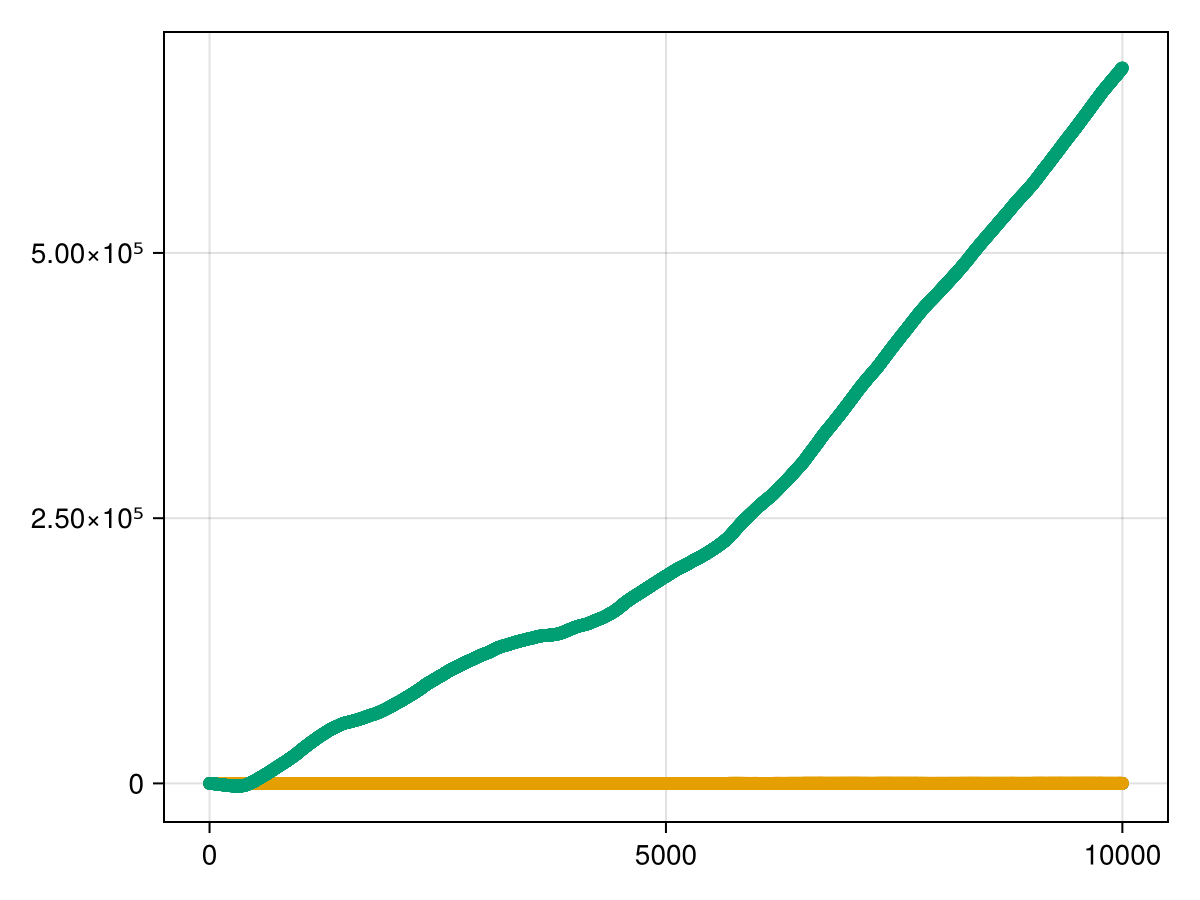

In [29]:
fap = scatterlines(xs)
scatterlines!(fap.axis, ys)
scatterlines!(fap.axis, zs)

# display(GLMakie.Screen(), fap)

fap

# Testing

In [113]:
# without the r/D dimensional prefactor
@latexrun function ff(chi, l; s=+1)
    ((4 * l) / (1 - chi)) * ((chi + s * sqrt(chi)) / (2 * l - 1 - s * sqrt(chi)))
    (4 * l * (chi + s * sqrt(chi))) / ((1 - chi) * (2 * l - 1 - s * sqrt(chi)))
end

L"$\mathrm{ff}\left( \chi, l; s = 1 \right) = \frac{4 \cdot l \cdot \left( \chi + s \cdot \sqrt{\chi} \right)}{\left( 1 - \chi \right) \cdot \left( 2 \cdot l - 1 - s \cdot \sqrt{\chi} \right)}$"

In [125]:
tals = @latexrun function ta(chi, l; s=+1)
    (2 * l * (2 * l - 1 - s * sqrt(chi))) / (1 - chi)
end
display(tals)
@latexrun function tb(chi, l; s=+1)
    (4 * l * (chi + s * sqrt(chi))) / ((1 - chi)^2)
end

L"$\mathrm{ta}\left( \chi, l; s = 1 \right) = \frac{2 \cdot l \cdot \left( 2 \cdot l - 1 - s \cdot \sqrt{\chi} \right)}{1 - \chi}$"

L"$\mathrm{tb}\left( \chi, l; s = 1 \right) = \frac{4 \cdot l \cdot \left( \chi + s \cdot \sqrt{\chi} \right)}{\left( 1 - \chi \right)^{2}}$"

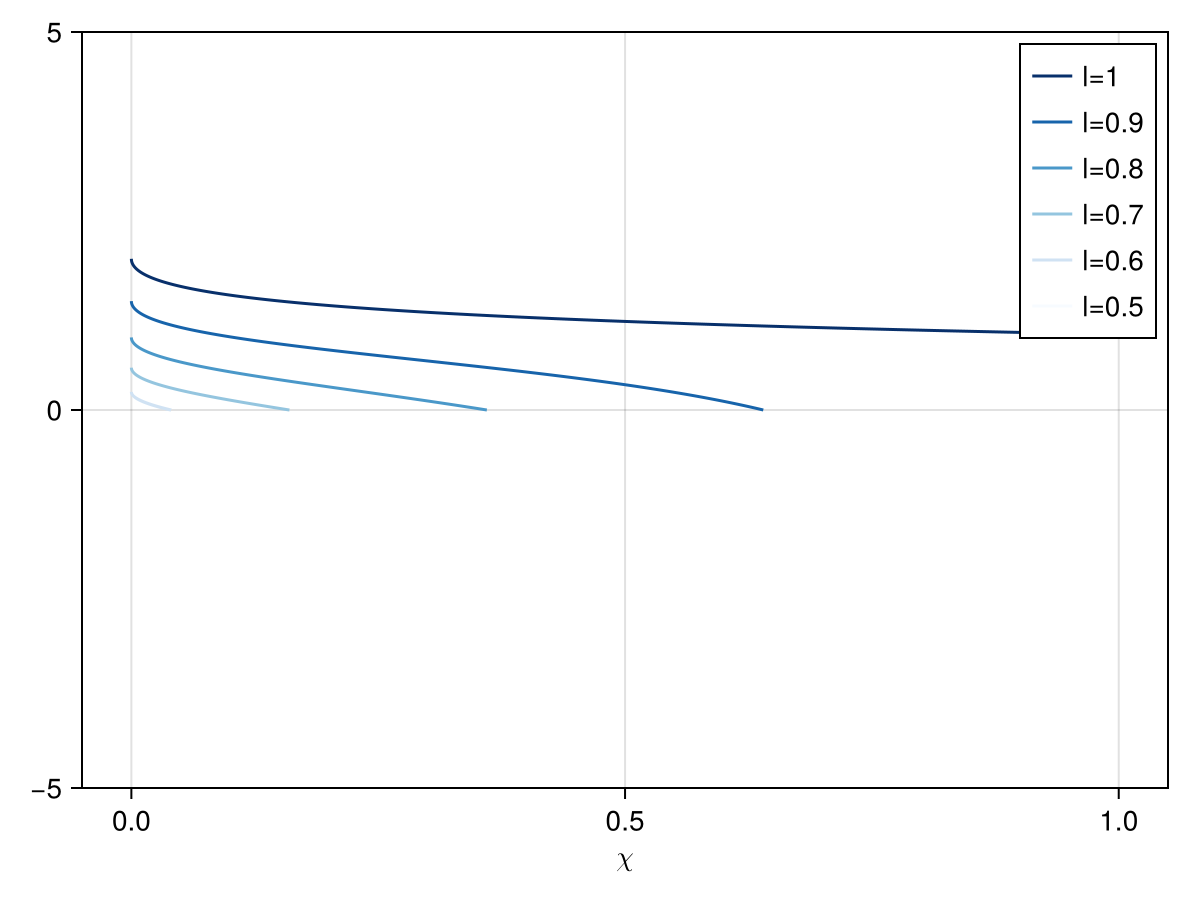

In [135]:
# ls = [0.5 + 1e-2, 0.75, 1. - 1e-2]
ls = range(1., 0.5, 6)
Nchis = 10000

fig = Figure()
ax = Axis(fig[1,1];
    xlabel=L"\chi",
    # ylabel=L"\text{most unstable lengthscale}",
)

for l in ls
    chimax = (2 * l - 1)^2
    chis = range(0., chimax, Nchis)
    
    lines!(ax, chis, ta.(chis, l);
        color=get(ColorSchemes.Blues, (l - 0.5) * 2),
        label=(@sprintf "l=%.3g" l),
    )
    # vlines!(ax, [(2 * l - 1)^2];
    #     color=get(ColorSchemes.Blues, (l - 0.5) * 2),
    #     linestyle=:dash,
    # )
end
axislegend(ax)

# display(GLMakie.Screen(), fig)
ylims!(-5., 5.)
fig

# MM FR Linstab lenghtscales

In [87]:
using Latexify

In [156]:
function Ktok(K)
    if K < zero(K)
        missing
    else
        sqrt(K)
    end
end
ktol(k) = 2 * pi / k
Ktol(K) = ktol(Ktok(K));

In [157]:
# without the r/D dimensional prefactor
@latexrun function K0(chi, l; s=+1)
    ((4 * l) / (1 - chi)) * ((chi + s * sqrt(chi)) / (2 * l - 1 - s * sqrt(chi)))
end

L"$\mathrm{K0}\left( \chi, l; s = 1 \right) = \frac{4 \cdot l}{1 - \chi} \cdot \frac{\chi + s \cdot \sqrt{\chi}}{2 \cdot l - 1 - s \cdot \sqrt{\chi}}$"

In [163]:
# without the r/D dimensional prefactor
@latexrun function Km(chi, l; s=+1)
    # ((2 * l) / ((1 - chi) * (2 * l - 1 - s * sqrt(chi)))) * (2 * l - 1 + s * 2 * (l - 3) * sqrt(chi) - 5 * chi)
    (2 * l) / ((1 - chi) * (2 * l - 1 - s * sqrt(chi))) * (2 * l - 1 + s * 2 * (l + 1) * sqrt(chi) + 3 * chi)
end

L"$\mathrm{Km}\left( \chi, l; s = 1 \right) = \frac{2 \cdot l}{\left( 1 - \chi \right) \cdot \left( 2 \cdot l - 1 - s \cdot \sqrt{\chi} \right)} \cdot \left( 2 \cdot l - 1 + s \cdot 2 \cdot \left( l + 1 \right) \cdot \sqrt{\chi} + 3 \cdot \chi \right)$"

## Plots wrt Kc/mr

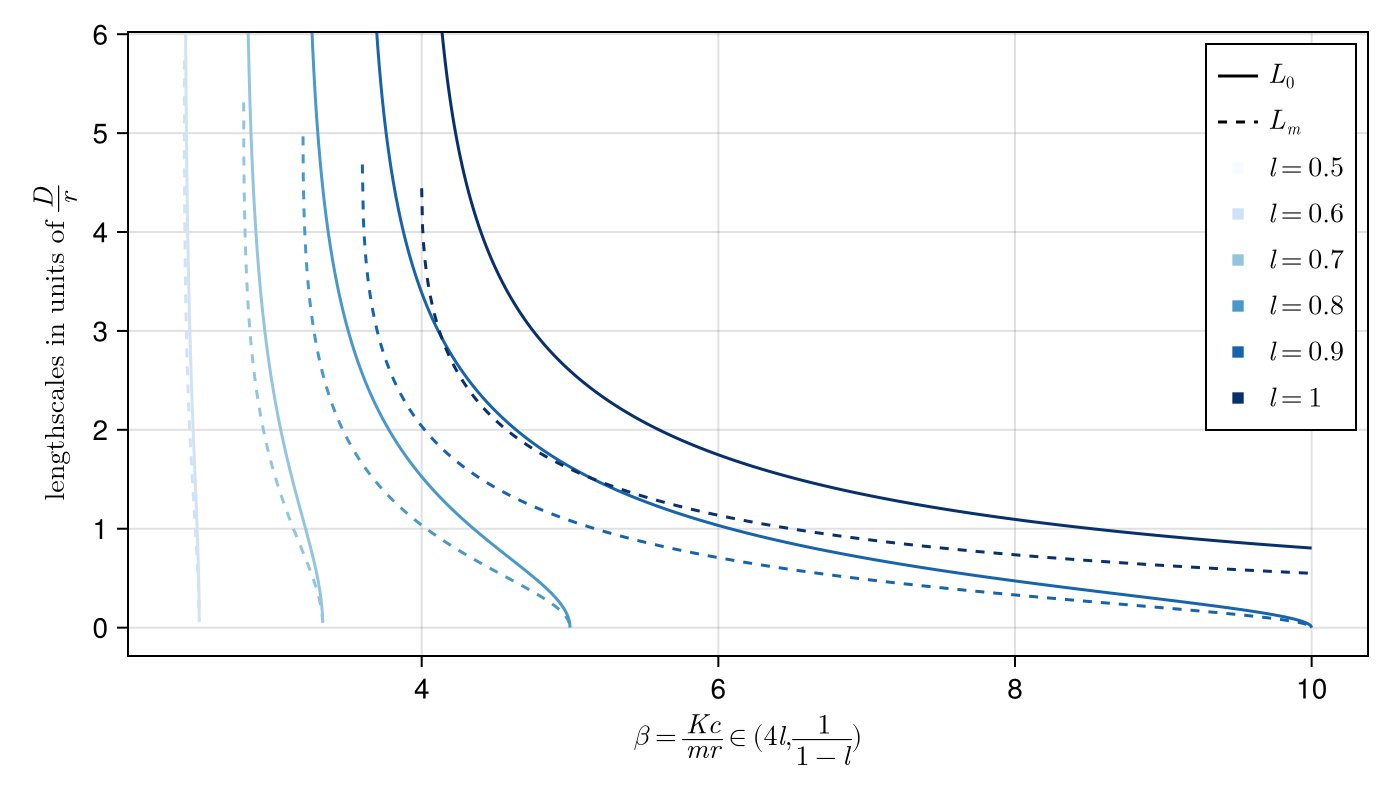

In [235]:
N = 1000
# ls = [0.5 + 1e-2, 0.75, 1. - 1e-2]
ls = range(0.5, 1., 6)

fig = Figure(;
    size=(700, 400)
)
ax = Axis(fig[1,1];
    xlabel=L"\beta = \frac{Kc}{mr} \in (4l, \frac{1}{1-l})",
    ylabel=L"\text{lengthscales in units of }\frac{D}{r}",
)

get_c(l) = get(ColorSchemes.Blues, (l - 0.5) * 2)
for l in ls
    ul = l == 1 ? 10 : 1 / (1 - l)
    betas = range(4 * l, ul, N)
    # betas = range(4 * l, 1 / (1 - 0.99), N)
    # betas = range(4 * l, 10, N)
    chis = 1 .- (4 * l) ./ betas

    xx = Ktol.(K0.(chis, l))
    lines!(ax, betas, xx;
        color=get(ColorSchemes.Blues, (l - 0.5) * 2),
        # marker='.',
        label=(latexstring(@sprintf "K_0, \\enspace l=%.3g" l)),
    )
    xx = Ktol.(Km.(chis, l))
    lines!(ax, betas, xx;
        color=get_c(l),
        linestyle=:dash,
        label=(latexstring(@sprintf "K_m, \\enspace l=%.3g" l)),
    )
    
    # vlines!(ax, [(2 * l - 1)^2, ((1 - l) / 5)^2];
    #     color=get(ColorSchemes.Blues, (l - 0.5) * 2),
    #     linestyle=:dash,
    # )
end
# axislegend(ax)

axislegend(ax,
    [
        LineElement(color=:black),
        LineElement(color=:black, linestyle=:dash),
        [MarkerElement(color=get_c(l), marker=:rect) for l in ls]...
    ],
    [L"L_0", L"L_m", [latexstring(@sprintf "l=%.3g" l) for l in ls]...]
)

# display(GLMakie.Screen(), fig)
# ylims!(0., 10.)
# xlims!(2., 10.)

Makie.save("./faf.pdf", fig)

fig

## Plots wrt chi

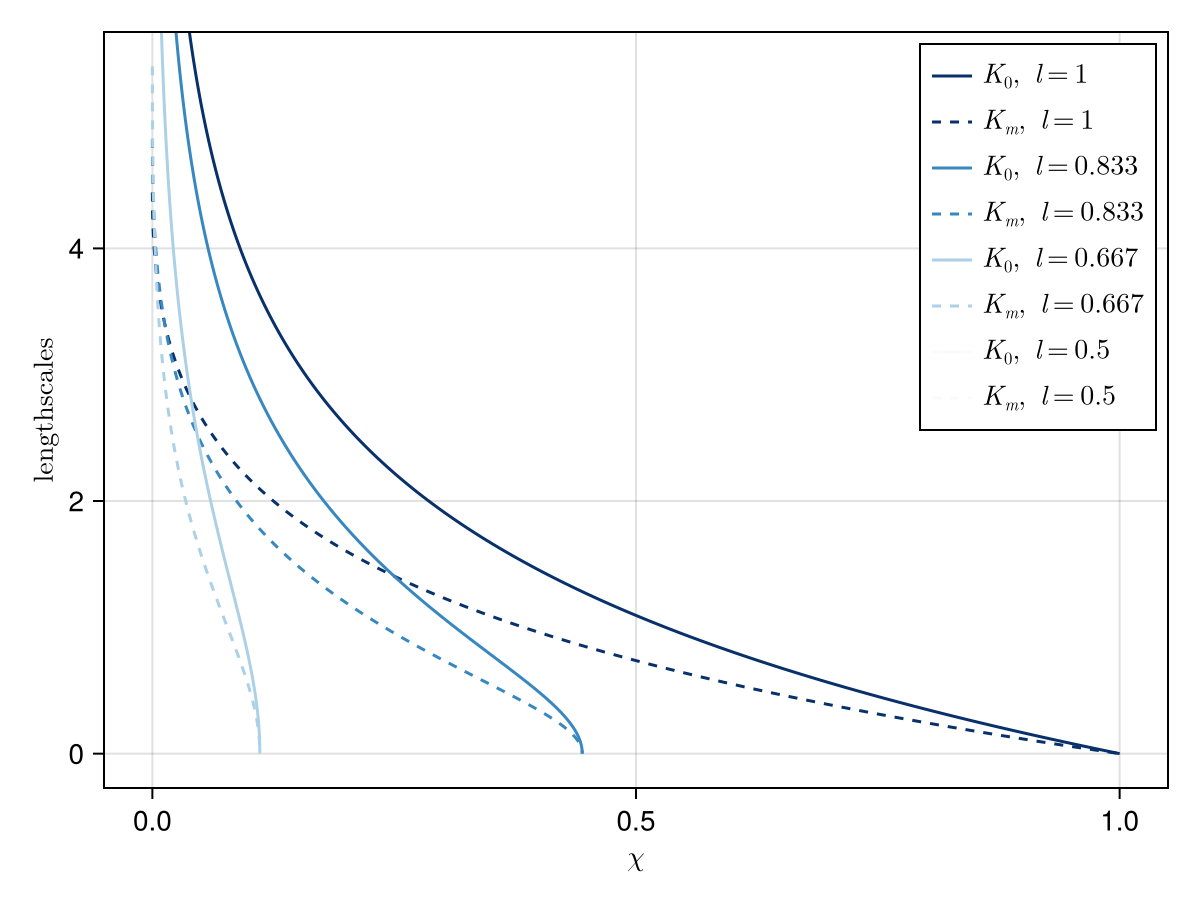

In [176]:
Nchis = 10000
# ls = [0.5 + 1e-2, 0.75, 1. - 1e-2]
ls = range(1., 0.5, 4)

fig = Figure()
ax = Axis(fig[1,1];
    xlabel=L"\chi",
    ylabel=L"\text{lengthscales}",
)

for l in ls
    chimax = (2 * l - 1)^2
    chis = range(0., chimax, Nchis)

    xx = Ktol.(K0.(chis, l))
    lines!(ax, chis, xx;
        color=get(ColorSchemes.Blues, (l - 0.5) * 2),
        # marker='.',
        label=(latexstring(@sprintf "K_0, \\enspace l=%.3g" l)),
    )
    xx = Ktol.(Km.(chis, l))
    lines!(ax, chis, xx;
        color=get(ColorSchemes.Blues, (l - 0.5) * 2),
        linestyle=:dash,
        label=(latexstring(@sprintf "K_m, \\enspace l=%.3g" l)),
    )
    
    # vlines!(ax, [(2 * l - 1)^2, ((1 - l) / 5)^2];
    #     color=get(ColorSchemes.Blues, (l - 0.5) * 2),
    #     linestyle=:dash,
    # )
end
axislegend(ax)

# display(GLMakie.Screen(), fig)
# ylims!(0., 10.)
fig